  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

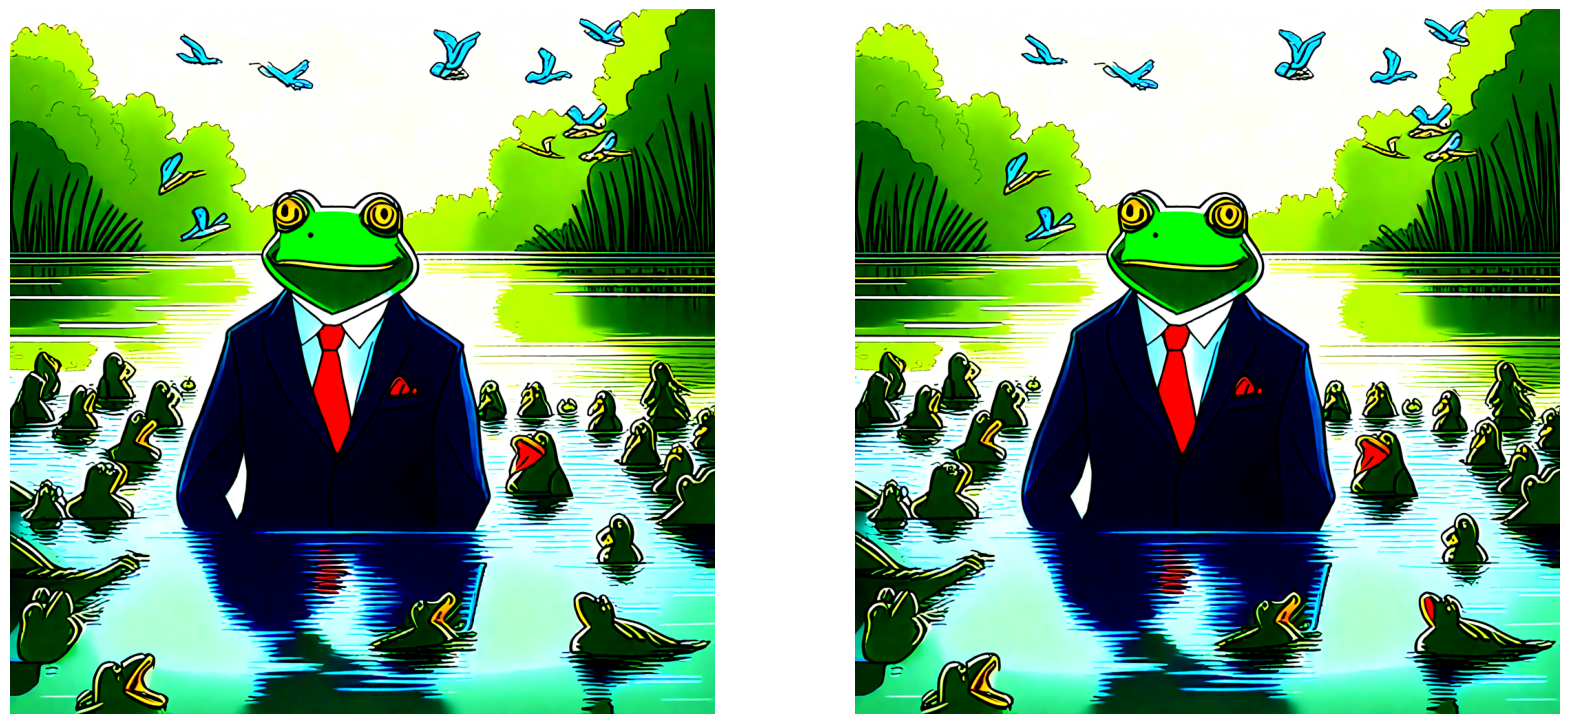

In [ ]:
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler, StableDiffusionXLPipeline
import torch
import numpy as np
NFE = 27

def timesteps_ddim(nfe):
  '''
  make sure last timestep is zero
  '''
  step_ratio = 1000 // nfe
  timesteps = (np.arange(0, nfe) * step_ratio).round()[::-1].copy().astype(np.int64)
  return timesteps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, local_files_only=True, variant="fp16").to(device)

#############################################
# DPMSOLVER-1
#############################################

pipe.scheduler = DPMSolverMultistepScheduler(
  solver_order=1, 
  algorithm_type='dpmsolver++', 
  final_sigmas_type='zero', 
  )


prompt = 'A frog in a suit giving a motivational speech at a pond, to an audience of ducks'

img_dpms = pipe(
  prompt, 
  guidance_scale=5,
  timesteps=timesteps_ddim(NFE), 
  return_dict=False,
  generator = torch.Generator(device=device).manual_seed(42),
  )[0][0]


#############################################
# DDIM
#############################################

pipe.scheduler = DDIMScheduler(
  timestep_spacing='leading', 
  clip_sample=False, # there is no clipping in the original realisation in git
  )

img_ddim = pipe(
  prompt, 
  guidance_scale=5,
  num_inference_steps=NFE, 
  return_dict=False,
  generator = torch.Generator(device=device).manual_seed(42),
  )[0][0]

#############################################
# IMG DIFF
#############################################

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].imshow(img_dpms)
ax[1].imshow(img_ddim)
ax[0].axis('off')
ax[1].axis('off')
plt.show();

In [29]:
torch.manual_seed(42)
model_output = torch.randn(1, 4, 128, 128)
sample = torch.randn(1, 4, 128, 128)

timesteps = timesteps_ddim(NFE)
timestep  = timesteps[0]

# DPMS

dpms_sched = DPMSolverMultistepScheduler(
  solver_order=1, 
  algorithm_type='dpmsolver++', 
  final_sigmas_type='zero'
  )

dpms_sched.set_timesteps(timesteps=timesteps_ddim(NFE))
dpms_sched._init_step_index(timestep)
res_dpms = dpms_sched.step(model_output, None, sample, return_dict=False)[0]

# DDIM

ddim_sched = DDIMScheduler(
  timestep_spacing='leading', 
  clip_sample=False
  )
ddim_sched.set_timesteps(NFE)
res_ddim = ddim_sched.step(model_output, timestep, sample, return_dict=True)[0]

torch.allclose(res_ddim, res_dpms, atol=1e-6)

True